# Recommender System

Python implementation of Andrew Ng's Coursera course "Introduction to Machine Learning", Chapter 8.  The problem is to create a movie recommender system that takes existing user ratings for movies and generates recommendations to other users.

In [258]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io
import re

## Part 1: Loading the movie rating dataset

The data set from Coursera was in Matlab format.  I went back to the original source (https://grouplens.org/datasets/movielens/) and got the small version of the data set.  This data set comes in separate CSV files for the movies, ratings, tags, and links.

In [2]:
links = pd.read_csv("datasets/ml-latest-small/links.csv").set_index("movieId")
ratings = pd.read_csv("datasets/ml-latest-small/ratings.csv")
tags = pd.read_csv("datasets/ml-latest-small/tags.csv")
movies = pd.read_csv("datasets/ml-latest-small/movies.csv")

In [3]:
#links.head()
#ratings.head()
#tags.head()
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
ratings.shape

(100004, 4)

In [6]:
# I found out that you can read in a Matlib .mat file with Scipy
ex8_movies = scipy.io.loadmat("datasets/ex8_movies.mat")

In [7]:
type(ex8_movies)

dict

In [8]:
ex8_movies

{'R': array([[1, 1, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'Y': array([[5, 4, 0, ..., 5, 0, 0],
        [3, 0, 0, ..., 0, 0, 5],
        [4, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 17:19:26 2011',
 '__version__': '1.0'}

From the course documentation, Y is 1682 x 943 matrix, containing ratings (1-5) of 1682 movies by 943 users.

R is 1682 x 943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i.

In [454]:
Y = ex8_movies["Y"]
print(type(Y))
print(Y.shape)
print(Y[0:10])

<class 'numpy.ndarray'>
(1682, 943)
[[5 4 0 ..., 5 0 0]
 [3 0 0 ..., 0 0 5]
 [4 0 0 ..., 0 0 0]
 ..., 
 [1 0 0 ..., 0 0 0]
 [5 0 0 ..., 0 0 3]
 [3 2 0 ..., 0 0 0]]


In [455]:
R = ex8_movies["R"]
print(type(R))
print(R.shape)
print(R[0:10])

<class 'numpy.ndarray'>
(1682, 943)
[[1 1 0 ..., 1 0 0]
 [1 0 0 ..., 0 0 1]
 [1 0 0 ..., 0 0 0]
 ..., 
 [1 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 1]
 [1 1 0 ..., 0 0 0]]


In [456]:
test = (R[0] == 1)[0:10]
print(test)

[ True  True False False  True  True False False False  True]


In [457]:
np.where(R[0]==1)

(array([  0,   1,   4,   5,   9,  12,  14,  15,  16,  17,  19,  20,  22,
         24,  25,  37,  40,  41,  42,  43,  44,  48,  53,  55,  56,  57,
         58,  61,  62,  63,  64,  65,  66,  69,  71,  72,  74,  76,  78,
         80,  81,  82,  83,  88,  91,  92,  93,  94,  95,  96,  98, 100,
        101, 105, 107, 108, 116, 119, 120, 123, 124, 127, 129, 130, 133,
        136, 137, 140, 143, 144, 147, 149, 150, 156, 157, 159, 161, 167,
        173, 176, 177, 180, 181, 183, 188, 192, 193, 197, 198, 199, 200,
        201, 202, 203, 208, 209, 212, 215, 221, 222, 229, 230, 231, 233,
        234, 241, 242, 243, 245, 246, 247, 248, 249, 250, 251, 252, 253,
        255, 261, 262, 264, 267, 270, 273, 274, 275, 276, 278, 279, 285,
        286, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 300,
        302, 304, 306, 307, 310, 311, 312, 313, 319, 321, 323, 324, 325,
        326, 329, 330, 331, 335, 337, 338, 339, 342, 343, 344, 346, 347,
        349, 356, 358, 359, 362, 364, 370, 373, 377

In [458]:
# print the average rating for movie number 1 (Toy Story)
print('Average rating for movie 1 (Toy Story): %.4f' %np.mean(Y[0,np.where(R[0]==1)]))

Average rating for movie 1 (Toy Story): 3.8783


Try to visualize the matrix.

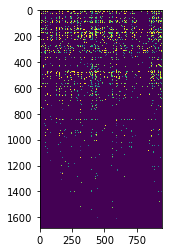

In [15]:
plt.imshow(Y)

In [16]:
# load in pre-trained weights
ex8_movieParams = scipy.io.loadmat('ex8/ex8_movieParams.mat')

In [17]:
type(ex8_movieParams)

dict

In [18]:
ex8_movieParams

{'Theta': array([[ 0.28544362, -1.68426509,  0.26293877, ...,  0.76723235,
         -1.10460164, -0.25186708],
        [ 0.50501321, -0.45464846,  0.31746244, ...,  1.09306336,
         -1.20029436, -0.39161676],
        [-0.43191656, -0.47880449,  0.84671111, ...,  1.36333976,
         -0.32523542, -0.19468212],
        ..., 
        [ 1.0586926 , -0.8087176 ,  0.56935771, ...,  0.80421422,
         -0.74346778, -0.11985885],
        [ 0.89058932, -0.12894734,  0.35560466, ...,  1.37426807,
         -0.7526549 , -0.81135311],
        [ 0.82414136, -0.38892594,  1.06940502, ...,  1.28423703,
         -0.98349993, -0.53184838]]),
 'X': array([[ 1.0486855 , -0.40023196,  1.19411945, ...,  0.861721  ,
         -0.69728994,  0.28874563],
        [ 0.78085123, -0.38562591,  0.52119779, ...,  0.70402073,
         -0.48583521, -0.56462407],
        [ 0.64150886, -0.54785385, -0.08379638, ...,  0.83854643,
         -0.69483208, -1.13479631],
        ..., 
        [ 0.21952237, -0.20047886,  0.

In [222]:
#extract X and Theta
X = ex8_movieParams["X"]
Theta = ex8_movieParams['Theta']
num_features = ex8_movieParams['num_features']
num_movies = ex8_movieParams['num_movies']
num_users = ex8_movieParams['num_users']
print(X.shape)
print(Theta.shape)

(1682, 10)
(943, 10)


## Part 2: Collaborative Filtering Cost Function

In the exercie, it says to reduce the size of all of these matrices so that things run faster.

In [223]:
num_users = 4
num_movies = 5
num_features = 3
X_small = X[0:num_movies, 0:num_features]
Theta_small = Theta[0:num_users, 0:num_features]
Y_small = Y[0:num_movies, 0:num_users]
R_small = R[0:num_movies, 0:num_users]
print(Y_small.shape)

(5, 4)


In [225]:
# define the collaborative filtering cost function 
def cofiCostFunction(params, Y, R, num_users, num_movies, num_features, lambdaval):
    # Unfold the X and Theta matrices from params
    X = params[0:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)
    # Initialie the cost
    J = 0
    # Compute the Cost Function
    M = (np.dot(X, Theta.T)-Y)**2
    # Unregularize Cost Function
    J = 1/2.*np.sum(R*M)
    # Add in Regularization
    J = J + (lambdaval / 2 * np.sum(Theta**2)) + (lambdaval / 2 * np.sum(X**2))
    return J

In [459]:
def cofiGradientFunction(params, Y, R, num_users, num_movies, num_features, lambdaval):
    # Compute the Gradients X_grad, Theta_grad
    # Loop over movies to compute X_grad for each movie
    # Unfold the X and Theta matrices from params
    X = params[0:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)
    # Initialize Gradients
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    # Loop over movies and compute X_grad for each movie
    for i in range(0,num_movies):
        Z = np.dot(((np.dot(X[i,:],Theta.T) - Y[i,:])*R[i,:]),Theta) + lambdaval * X[i,:]
        X_grad[i,:] = Z
    # End of loop
    # Loop over users to compute Theta_grad for each user
    for j in range(0,num_users):
        Z = np.dot(((np.dot(Theta[j,:],X.T) - Y[:,j].T)*R[:,j]),X) + lambdaval * Theta[j,:]
        Theta_grad[j,:] = Z
    # End of loop
    grad = np.concatenate((X_grad, Theta_grad)).flatten()    
    return np.asarray(grad)

In [226]:
# test the cost function
J = cofiCostFunction(np.concatenate((X_small,Theta_small)).flatten(), Y_small, R_small, num_users, num_movies, num_features, 0)
print("Cost function of loaded parameters:", J)

Cost function of loaded parameters: 22.2246037257


Yay!  That is what the document says I should get at this point.

## Part 3: Collaborative Filtering Gradient

Once your cost function matches, you should now implement / check the collaborative filtering gradient function.

In [121]:
X_t = np.random.rand(4,3)
Theta_t = np.random.rand(5,3)
Y_t = np.dot(X_t, Theta_t.T)
print("Y_t: ")
print(Y_t)
Y_t[np.where(Y_t > 0.5)] = 0
#Y_t[(np.where(Y_t)) > 0.5] = 0
print("Y_t zeroed:")
print(Y_t)
R_t = np.zeros(Y_t.shape)
print("R_t:")
print(R_t)
print((Y_t != 0))
R_t[(Y_t != 0)] = 1
print(R_t)
print(Y_t.shape[1])

Y_t: 
[[ 0.78177414  0.6760293   0.21172172  0.65965177  0.76561657]
 [ 1.10071406  0.94470187  0.19716257  1.08739012  0.96260907]
 [ 1.5557393   1.34148705  0.31794945  1.33241546  1.17942779]
 [ 1.09731595  0.94826876  0.23153389  0.86443381  0.73898668]]
Y_t zeroed:
[[ 0.          0.          0.21172172  0.          0.        ]
 [ 0.          0.          0.19716257  0.          0.        ]
 [ 0.          0.          0.31794945  0.          0.        ]
 [ 0.          0.          0.23153389  0.          0.        ]]
R_t:
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
[[False False  True False False]
 [False False  True False False]
 [False False  True False False]
 [False False  True False False]]
[[ 0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.]]
5


In [160]:
def computeNumericalGradient(J, theta, Y, R, num_users, num_movies, num_features, lambdaval):
    # COMPUTENUMERICALGRADIENT Computes the gradient using "finite differences"
    # and gives us a numerical estimate of the gradient.
    # numgrad = COMPUTENUMERICALGRADIENT(J, theta) computes the numerical
    # gradient of the function J around theta. Calling y = J(theta) should
    # return the function value at theta.

    # Notes: The following code implements numerical gradient checking, and 
    #    returns the numerical gradient.  It sets numgrad(i) to (a numerical 
    #    approximation of) the partial derivative of J with respect to the 
    #    i-th input argument, evaluated at theta. (i.e., numgrad(i) should 
    #    be the (approximately) the partial derivative of J with respect 
    #    to theta(i).)            

    numgrad = np.zeros(theta.shape);
    perturb = np.zeros(theta.shape);
    e = 1e-4;
    #print("NumericalGrad theta.size: {}".format(theta.size))
    p = [None] * theta.size
    #print(range(0,theta.size))
    for p in range(0,theta.size):
        # Set perturbation vector
        perturb[p] = e;
        loss1 = J(theta - perturb, Y, R, num_users, num_movies, num_features, lambdaval);
        loss2 = J(theta + perturb, Y, R, num_users, num_movies, num_features, lambdaval);
        # Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / (2*e);
        #print("NumGrad at {} = {}".format(p,numgrad[p]))
        perturb[p] = 0;
    
    return numgrad

In [161]:
# define a function to check the Cost function that you defined above.
# Creates a collaborative filtering problem
# to check your cost function and gradients.
# It will output the analytic gradients produced
# by your code and the numerical gradients (computed
# by the computeNumericalGradient function). These
# two gradient computations should result in similar results.
def checkCostFunction(lambdaval=None):
    # set lambda
    if not lambdaval:
        lambdaval = 0
    print("Using lambdaval:",lambdaval)
    # Create a small problem
    X_t = np.random.rand(4, 3)
    Theta_t = np.random.rand(5,3)
    # Zap out most of the entries
    Y_t = np.dot(X_t, Theta_t.T)
    Y_t[np.where(Y_t > 0.5)] = 0
    R_t = np.zeros(Y_t.shape)
    R_t[(Y_t != 0)] = 1
    # Run Gradient checking
    X = np.random.rand(X_t.shape[0], X_t.shape[1])
    Theta = np.random.rand(Theta_t.shape[0], Theta_t.shape[1])
    num_movies, num_users = Y_t.shape
    num_features = Theta_t.shape[1]
    print("users {}, movies {}, features {}".format(num_users, num_movies, num_features))
    numGrad = computeNumericalGradient(cofiCostFunction, np.concatenate((X,Theta)).flatten(), 
                                       Y_t, R_t, num_users, num_movies, num_features, lambdaval)
    cost = cofiCostFunction(np.concatenate((X,Theta)).flatten(), Y_t, R_t, num_users, 
                                  num_movies, num_features, lambdaval)
    grad = cofiGradientFunction(np.concatenate((X,Theta)).flatten(), Y_t, R_t, num_users, 
                                  num_movies, num_features, lambdaval)
    #print(numGrad)
    #print(grad.flatten())
    diff = np.linalg.norm(numGrad-grad.flatten()) / np.linalg.norm(numGrad+grad.flatten())
    print("If your backprogation is correct, then the relative difference")
    print("will be small (less than 1e-9).")
    print("Relative Differece:", diff)

In [247]:
# check the cost function
checkCostFunction()

Using lambdaval: 0
users 5, movies 4, features 3
If your backprogation is correct, then the relative difference
will be small (less than 1e-9).
Relative Differece: 6.98975590555e-13


## Part 4: Collaborative Filtering Cost Regularization

Implement regularization to the cost function (above)

In [208]:
# test the cost function
J = cofiCostFunction(np.concatenate((X_small,Theta_small)).flatten(), 
                           Y_small, R_small, num_users, num_movies, num_features, 1.5)
print("Cost function of loaded parameters:", J)

Cost function of loaded parameters: 31.3440562443


That's the right answer!  Yay.

## Part 5: Collaborative Filtering Gradient Regularization

Implement regularization to the gradient function (above)

In [229]:
# check the cost function
checkCostFunction(1.5)

Using lambdaval: 1.5
users 5, movies 4, features 3
If your backprogation is correct, then the relative difference
will be small (less than 1e-9).
Relative Differece: 1.30174204179e-12


## Part 6: Entering ratings for a new user

Before we will train the collaborative filtering model, we will first add ratings that correspond to a new user that we just observed. This part of the code will also allow you to put in your own ratings for the movies in our dataset!

First, define function for loading movie list from text file.

In [451]:
def loadMovieList():
    # GETMOVIELIST reads the fixed movie list in movie.txt and returns a
    # cell array of the words
    # movieList = GETMOVIELIST() reads the fixed movie list in movie.txt 
    # and returns a cell array of the words in movieList.
            
    # Store all movies in array movieList
    n = 1682  # Total number of movies 
    
    # Initialize return list
    movieList = []
    # Read the fixed movieulary list
    # FIX: had to change encoding to latin-1
    with open('datasets/movie_ids.txt','r', encoding='latin-1') as f:
        for line in f:
            part = line.split(' ', 1)
            idx = part[0]
            movie = part[1]
            # Try regular expression instead
            #if int(idx) < 100:
            #    print("part01[0]: {}".format(part01[0]))
            #    print("id: {}, movie: {}".format(idx, movie))
            #movie = re.match(pattern=r"\s+\w+\s*\w*\s+", string=line)
            # Format should be:
            # id moviename (year)
            movieList.append(movie.strip())
    return movieList

In [452]:
movieList = loadMovieList() # load in the movie list
movieList[1:10]

['GoldenEye (1995)',
 'Four Rooms (1995)',
 'Get Shorty (1995)',
 'Copycat (1995)',
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 'Twelve Monkeys (1995)',
 'Babe (1995)',
 'Dead Man Walking (1995)',
 'Richard III (1995)']

In [433]:
# initialize my_ratings
my_ratings = np.zeros((1682,1))

In [434]:
# set some ratings for some other movies
my_ratings[0] = 4  # Toy Story
my_ratings[97] = 2 # Silence of the Lambs

In [435]:
# a bunch more
my_ratings[6] = 3
my_ratings[11] = 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

In [440]:
print("New user ratings:")
for i in range(len(my_ratings)):
    if  my_ratings[i] > 0:
        print("Rated {} for {}".format(my_ratings[i,0], movieList[i]))

New user ratings:
Rated 4.0 for Toy Story 
Rated 3.0 for Twelve Monkeys 
Rated 5.0 for Usual Suspects, The 
Rated 4.0 for Outbreak 
Rated 5.0 for Shawshank Redemption, The 
Rated 3.0 for While You Were Sleeping 
Rated 5.0 for Forrest Gump 
Rated 2.0 for Silence of the Lambs, The 
Rated 4.0 for Alien 
Rated 5.0 for Die Hard 2 
Rated 5.0 for Sphere 


## Part 7: Learning Movie Ratings

Now, we will train the collaborative filtering model on a movie rating dataset of 1682 movies and 943 users.

In [441]:
print("Trainng collaborative filtering...")

Trainng collaborative filtering...


In [442]:
def normalizeRatings(Y, R):
    # NORMALIZERATINGS Preprocess data by subtracting mean rating for every 
    # movie (every row)
    # [Ynorm, Ymean] = NORMALIZERATINGS(Y, R) normalized Y so that each movie
    # has a rating of 0 on average, and returns the mean rating in Ymean.

    m, n = Y.shape
    Ymean = np.zeros(m)
    Ynorm = np.zeros(Y.shape)
    for i in range(0,m):
        idx = np.nonzero(R[i,:] == 1)
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]
        
    return Ynorm, Ymean

In [443]:
import scipy.optimize as op
# make sure orginal data is loaded
Y = ex8_movies["Y"]
R = ex8_movies["R"]
# print(Y.shape)
# print(R.shape)

# Add in our own ratings to the data matrix
Y = np.hstack([my_ratings, Y])
R = np.hstack([(my_ratings != 0), R])
# print(Y.shape)
# print(R.shape)

# Normalize all of the ratings
[Ynorm, Ymean] = normalizeRatings(Y,R)

# Useful values
num_movies, num_users = Y.shape
num_features = 10

# set initial parameters
X = np.random.rand(num_movies, num_features)
Theta = np.random.rand(num_users, num_features)
#print("X shape:", X.shape)
#print("Theta shape:", Theta.shape)
#print("Y shape:", Y.shape)
#print("R shape:", R.shape)
#print("user: {}, movies: {}, features: {}".format(num_users, num_movies, num_features))
#initial_paramters = np.concatenate((X, Theta)).flatten()
# Try vstack...
initial_paramters = np.vstack([X, Theta]).flatten()
#print("Init params shape: {}".format(initial_paramters.shape))
#print("Init params ndim: {}".format(initial_paramters.ndim))
# Set Regularization
lambdaval = 10
# Set options for fmincg
args = (Y, R, num_users, num_movies, num_features, lambdaval)
opts = {'maxiter' : 100,    # override default value.
            'disp' : True,    # non-default value.
            'gtol' : 1e-5,    # default value.
            'norm' : np.inf,  # default value.
            'eps' : 1.4901161193847656e-08}  # default value.
theta = op.minimize(fun = cofiCostFunction,
                    x0 = initial_paramters,
                    args = args,
                    method = 'CG',
                    jac = cofiGradientFunction,
                    options = opts)

         Current function value: 72092.780314
         Iterations: 100
         Function evaluations: 148
         Gradient evaluations: 148


Unfold the resulting theta back into X and Theta

In [444]:
X = theta.x[0:num_movies*num_features].reshape(num_movies, num_features)
Theta = theta.x[num_movies*num_features:].reshape(num_users, num_features)
print("Recommender system learning complete")

Recommender system learning complete


## Part 8: Recommendations for you!

After training the model, you can now make recommendations by computing the predictions matrix.

In [453]:
#print("X shape: {}".format(X.shape))
#print("Theta shape: {}".format(Theta.shape))
# prediction matrix
p = np.dot(X, Theta.T)
# my predictions
#print("Ymean shape: {}".format(Ymean.shape))
#print(Ymean.T)
#print("p[:,0]")
#print(p[:,0])
my_predictions = p[:,0] + Ymean.T
# print("my_pred shape: {}".format(my_predictions.shape))
# print(type(my_predictions))
#print("my pred size: {}".format(my_predictions.shape))

# reload movie list
movieList = loadMovieList()

# sort the recommendations for you
# print(np.argmax(my_predictions))
# print(my_predictions[312])
# print(movieList[312])
I = np.argsort(my_predictions)[::-1]

print("\nTop 10 Recommendations for you.")
for i in range(10):
    j = I[i]
    print("Predicting rating {:.2f} for movie {}".format(my_predictions[I[i]], movieList[I[i]]))
    
print("\nOriginal Ratings provided.")
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print("Rated {:.2f} for movie {}".format(my_ratings[i,0], movieList[i]))
    




Top 10 Recommendations for you.
Predicting rating 8.56 for movie Star Wars (1977)
Predicting rating 8.45 for movie Titanic (1997)
Predicting rating 8.36 for movie Shawshank Redemption, The (1994)
Predicting rating 8.24 for movie Raiders of the Lost Ark (1981)
Predicting rating 8.17 for movie Schindler's List (1993)
Predicting rating 8.13 for movie Good Will Hunting (1997)
Predicting rating 8.05 for movie Usual Suspects, The (1995)
Predicting rating 8.05 for movie Empire Strikes Back, The (1980)
Predicting rating 8.02 for movie Braveheart (1995)
Predicting rating 7.97 for movie Godfather, The (1972)

Original Ratings provided.
Rated 4.00 for movie Toy Story (1995)
Rated 3.00 for movie Twelve Monkeys (1995)
Rated 5.00 for movie Usual Suspects, The (1995)
Rated 4.00 for movie Outbreak (1995)
Rated 5.00 for movie Shawshank Redemption, The (1994)
Rated 3.00 for movie While You Were Sleeping (1995)
Rated 5.00 for movie Forrest Gump (1994)
Rated 2.00 for movie Silence of the Lambs, The (1991